#  Coursera Capstone Project - The Battle of Neighbourhoods

## Week 2 

## Introduction <a name="introduction"></a>

New York City is the largest and most populous city in the United States, 2018 it's population was 8,398,748. It consists of five boroughs – Brooklyn, Queens, Manhattan, The Bronx, and Staten Island, each of which is a separate county of the State of New York. Each borough has its own demographic, cultural, linguistic and financial specificities.   

But you don't have to be Italian to like pizza. I mean a good pizza, made according to an old Italian recipe.   
Then a delicious espresso. Yes, a well crafted espresso tastes great. And ice cream. 

  
In this project, I'm going to **explore the location** of good, high rated **Italian restaurants** in New York City and **find a place where such a restaurant is missing**. We will look for highly populated areas with not many other Italian restaurants in vicinity. 
  

  
  

#### Goal and stakeholders 

The goal of this project is to explore the following questions:  
**1. What is best location in New York City for italian cuisine?**  
**2. Which areas lack italian resturants?  **

**Stakeholders** interested in the problem:  
Investors planning to open an Italian restaurant


## Data <a name="data"></a>

We will use the following data:

#### 1. New York City data to explore various neighborhoods of New York City.   
This dataset covers boroughs along with their neighborhoods, latitude and longitude  

Dataset source:   
https://geo.nyu.edu/catalog/nyu_2451_34572
 

####  2. GeoSpace data
The geo space data allow to get the New York Borough boundaries.   
It let us visualize choropleth map.  
  
Source:   
https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm


#### 3. Location of the Italian restaurants in New York City

a) By using the Fousquare API we will get all the venues in each neighborhood.   
b) Then we can filter out only Italian restaurants.  
c) We can also find ratings, tips and like count for each restaurant.   
That allows us to sort and visualize the data.  

Source:   
**Fousquare API**  
 <br><br><br>

## Methodology <a name="methodology"></a>

In this project we want to detect areas of New York that have a low density of Italian restaurant bit a high population density. 

First, We have collected the data:   
* location of Boroughs and Neighborhoods 
* location of Italian restaurant in each Neighborhood (within 1500 m from their center) 
* the population of the Boroughs

In the next step we analysed the '**restaurant density**' across the Boroughs of New York.
In the final step we focused on the most populated areas and filtered out the Neighborhoods with the least number of Italian restaurants. <br><br>
These are the most promising areas which should be attractive to investors.

### Load dependencies

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import requests
import json
import os

import geocoder
from geopy.geocoders import Nominatim 

import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#### Data sources and variables

In [62]:
newYorkUrl='https://cocl.us/new_york_dataset'

cityName = 'New York City, NY' 

#### Define Helper Functions

In [14]:
# get geo location of address
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_new_york_data(url):
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

def get_location_of_NYC(name):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinates of {} are {}, {}.'.format(name, latitude, longitude))
    return latitude, longitude
    

def create_map():
    latitude, longitude = get_location_of_NYC(cityName)
    neighborhoods  = nyc_data
    map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
    # add markers to map
    for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  
    return map_newyork
        
# get top 400 venues within the neighborhoods
def get_venues(lat,lng, CLIENT_ID, CLIENT_SECRET):
    radius=1500
    LIMIT=400
    VERSION = '20180605' 
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_lat = row['venue']['location']['lat']
            venue_lng =  row['venue']['location']['lng']
            venue_details.append([venue_id,venue_name,venue_category, venue_lat, venue_lng])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category', 'Latitude', 'Longitude']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


## Distribution of Italian Restaurants in New York City

In [122]:
latitude, longitude = get_location_of_NYC(cityName)

The geograpical coordinates of New York City, NY are 40.7127281, -74.0060152.


#### Dataframe
Let's create a Dataframe with Boroughs, Neighborhoods and their coordinates
<br>

In [ ]:
nyc_data = get_new_york_data(newYorkUrl)
print('New York City has {} boroughs and {} nyc_data.'.format(len(nyc_data['Borough'].unique()),
                                                                   nyc_data.shape[0]))

In [11]:
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Visualize the neigborhoods 
Dokladnie rzecz biorac mapa nie przedstawia granic osieli? tylko ich centra.

In [12]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)
neighborhoods = nyc_data
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], 
                                           
        neighborhoods['Longitude'], neighborhoods['Borough'], 
                                           neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

In [13]:
CLIENT_ID = 'UIEPMQ55WJXAQRJYRO0L1ULTMVPCZNVBUDAQKHQ1LSZDUOJP' 
CLIENT_SECRET = 'UAW2DHGJEMVFGUVYZYKBODQH3S144P10GHUYUOOECKY1LI5O' 
VERSION = '20180605' 

##   Foursquare

### Get the top 400 venues within a radius of 1500 m from the center of every neighborhood
Let's use Foursquare API to get info on Italian restaurants in each neighborhood.  
We're interested in venues in proper Italian restaurants, we won't care about places like coffe shops or bakeries etc. 

In [61]:
# italian restaurants for each neighborhood
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude, CLIENT_ID, CLIENT_SECRET)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(nyc_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category, latitude, longitude =resturant_detail
        italian_rest = italian_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Latitude' : latitude,
                                                'Longitude' : longitude
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:2
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:1
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:2
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:4
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:7
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Resturants in Fordham, Bronx:15
( 18 / 306 ) Italian Resturants in East Tremont, Bronx

( 141 / 306 ) Italian Resturants in Sunnyside, Queens:1
( 142 / 306 ) Italian Resturants in East Elmhurst, Queens:1
( 143 / 306 ) Italian Resturants in Maspeth, Queens:2
( 144 / 306 ) Italian Resturants in Ridgewood, Queens:2
( 145 / 306 ) Italian Resturants in Glendale, Queens:0
( 146 / 306 ) Italian Resturants in Rego Park, Queens:2
( 147 / 306 ) Italian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Italian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Italian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Italian Resturants in College Point, Queens:2
( 151 / 306 ) Italian Resturants in Whitestone, Queens:4
( 152 / 306 ) Italian Resturants in Bayside, Queens:2
( 153 / 306 ) Italian Resturants in Auburndale, Queens:2
( 154 / 306 ) Italian Resturants in Little Neck, Queens:6
( 155 / 306 ) Italian Resturants in Douglaston, Queens:6
( 156 / 306 ) Italian Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Italian Resturants in Bellerose, Queens:3
( 158 / 306 ) Italian Resturants

( 276 / 306 ) Italian Resturants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Italian Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Italian Resturants in Sunnyside Gardens, Queens:1
( 279 / 306 ) Italian Resturants in Blissville, Queens:1
( 280 / 306 ) Italian Resturants in Fulton Ferry, Brooklyn:3
( 281 / 306 ) Italian Resturants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Italian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Italian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Italian Resturants in Dumbo, Brooklyn:2
( 285 / 306 ) Italian Resturants in Manor Heights, Staten Island:2
( 286 / 306 ) Italian Resturants in Willowbrook, Staten Island:5
( 287 / 306 ) Italian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Italian Resturants in Egbertville, Staten Island:8
( 289 / 306 ) Italian Resturants in Roxbury, Queens:0
( 290 / 306 ) Italian Resturants in Homecrest, Brooklyn:2
( 291 / 306 ) Italian Resturants in Middle Village, Queens:2
( 292 / 306 ) Itali

#### Clean data

In [63]:
a=italian_rest.copy()
italian_rest.drop_duplicates(subset='ID', keep='last', inplace=True)
print("There are {} italian restaurants in 306 neighborhoods".format(italian_rest.shape[0]))

There are 337 italian restaurants in 306 neighborhoods


In [64]:
italian_rest.head(15)

,Borough,Neighborhood,ID,Name,Latitude,Longitude
5,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,40.900638,-73.867724
6,Bronx,Woodlawn,4d9275a77ac3a35d6eb6c125,La Grotta II,40.907003,-73.872041
7,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,40.901218,-73.861698
8,Bronx,Woodlawn,5986672ef5e9d70849d99381,Casa Mia,40.905293,-73.858027
18,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood,40.849542,-73.787317
19,Bronx,City Island,55905336498e1a9217de2a7a,Scavello's On The Island,40.841418,-73.784330
20,Bronx,City Island,4b80a1c3f964a520488230e3,Portofino Restaurant,40.853321,-73.790693
51,Bronx,High Bridge,4cfe75a2feec6dcb0d1b5836,Antika Restaurant & Pizzeria,40.838778,-73.941210
52,Bronx,High Bridge,4b75e189f964a520b72b2ee3,AquaMarina,40.843199,-73.939169
59,Bronx,Port Morris,4e6acfb1ae60950955a9b02b,Wish 37,40.807011,-73.927563


#### Visualize the location of the italian restaurants in New York

In [18]:
# check data
list(zip(italian_rest['Latitude'], italian_rest['Longitude'], italian_rest['Name']))[:5]

[(40.90121764767051, -73.86169833552508, 'Rivers Edge'),
 (40.905293, -73.858027, 'Casa Mia'),
 (40.86448322844173, -73.82789397598344, 'Olive Garden'),
 (40.9054667242996, -73.90042336967397, 'Beccofino'),
 (40.90648305752465, -73.90396530525271, "Madison's")]

In [21]:
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, name in zip(italian_rest['Latitude'], italian_rest['Longitude'], italian_rest['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8).add_to(map_restaurants)  
    
map_restaurants

#### Let's cluster and count the restaurants 

In [20]:
from folium import plugins

map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

restaurants = plugins.MarkerCluster().add_to(map_restaurants)

for lat, lng, name in zip(italian_rest['Latitude'], italian_rest['Longitude'], italian_rest['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8).add_to(restaurants)  
    
map_restaurants

As we can see, the italian restaurants are not really equaly distributed.

## Population of New York City
Let's look at the distribution of population density in New York.

In [27]:
nyc_population = pd.read_csv('New_York_City_Population_By_Boroughs.csv')
nyc_population = nyc_population[['Borough', '2010 Population']]

In [48]:
nyc_population.sort_values('2010 Population', ascending=False)

,Borough,2010 Population
1,Brooklyn,2504700
3,Queens,2230722
2,Manhattan,1585873
0,Bronx,1385108
4,Staten Island,468730


# Analysis <a name="analysis"></a>

### Bring it together: Density of population and Italian restaurants

In [41]:
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)
ny_geo = 'nycboroughboundaries.geojson'

restaurants = plugins.MarkerCluster().add_to(map_restaurants)

map_restaurants.choropleth(
    geo_data=ny_geo,
    data=nyc_population,
    columns=['Borough', '2010 Population'],
    key_on='feature.properties.borough',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population'
)

for lat, lng, name in zip(italian_rest['Latitude'], italian_rest['Longitude'], italian_rest['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8).add_to(restaurants)  

map_restaurants

C:\Users\KSpisak\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<br>  
Let's take a closer look at the most populated areas:

In [42]:
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)
ny_geo = 'nycboroughboundaries.geojson'

restaurants = plugins.MarkerCluster().add_to(map_restaurants)

map_restaurants.choropleth(
    geo_data=ny_geo,
    data=nyc_population,
    columns=['Borough', '2010 Population'],
    key_on='feature.properties.borough',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population'
)

for lat, lng, name in zip(italian_rest['Latitude'], italian_rest['Longitude'], italian_rest['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8).add_to(restaurants)  

map_restaurants

C:\Users\KSpisak\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<br>
The most densely populated boroughs (red) are Brooklyn and Queens.  
We can see which areas of these Boroughs have only few Italian restaurants. **They are the areas we should care about**.
<br><br>
Let's look for neighborhoods where there are few (or no at all) Italian restaurants.

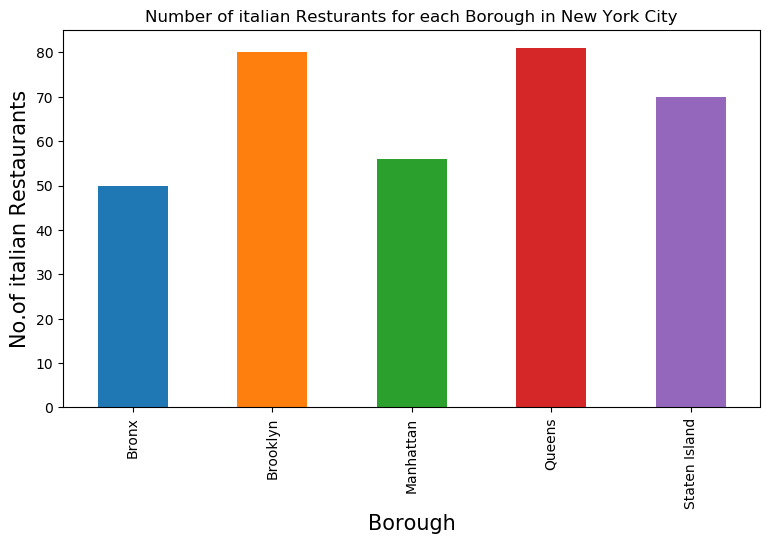

In [68]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of italian Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of italian Restaurants', fontsize=15)
italian_rest.groupby('Borough')['ID'].count().plot(kind='bar')
plt.show()

In [65]:
restPerNeighborhood = italian_rest.groupby('Neighborhood')['ID'].count().sort_values(ascending=False)

restPerNeighborhood.head()

Neighborhood
Belmont            15
West Village        9
Bay Terrace         7
Richmond Valley     7
Clinton Hill        6
Name: ID, dtype: int64

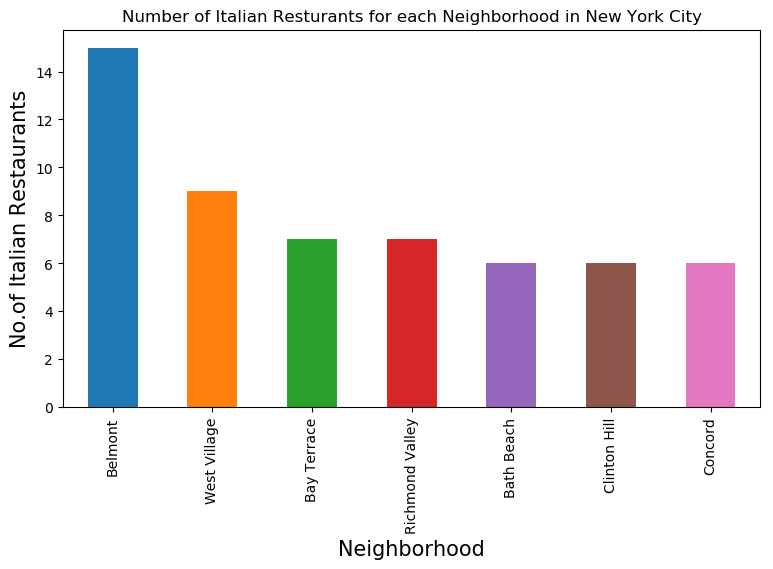

In [67]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Italian Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Italian Restaurants', fontsize=15)
italian_rest.groupby('Neighborhood')['ID'].count().nlargest(7).plot(kind='bar')
plt.show()

<br>
As you can see, most Italian restaurants are in the Belmont area.   
This is not a coincidence.  
As a result of its cultural history and wide array of Italian businesses, Belmont is known as the **"Little Italy".  **
<br>
<br>
Now, Let's check out the neighborhoods of **Brooklyn** and **Queens**.

In [95]:
neighbQueens = italian_rest[italian_rest.Borough == 'Queens']
neighbBrooklyn = italian_rest[italian_rest.Borough == 'Brooklyn']

Let's look at the data

In [96]:
neighbBrooklyn.head()

,Borough,Neighborhood,ID,Name,Latitude,Longitude
126,Brooklyn,Bay Ridge,4adb7364f964a520a32721e3,Areo Ristorante,40.624415,-74.030782
127,Brooklyn,Bay Ridge,4e732dff45dd41e9ccce1987,Giacomo's Wood Fired Pizza & Trattoria,40.628535,-74.029051
133,Brooklyn,Bensonhurst,4b3a8513f964a520336925e3,Europa Pizzeria,40.616583,-73.985708
134,Brooklyn,Bensonhurst,4fcc08eebb3d3d2d8021af06,Tony's Pizzeria,40.619118,-74.008596
135,Brooklyn,Bensonhurst,4b721bbcf964a520256f2de3,Tommaso's,40.611561,-74.011969


In [97]:
neighbQueens.head()

,Borough,Neighborhood,ID,Name,Latitude,Longitude
351,Queens,Astoria,5010b169e4b05edd9983ec7d,Antika Restaurant & Pizzeria,40.764903,-73.917158
354,Queens,Jackson Heights,4a82d6adf964a5206ff91fe3,Uncle Peter's,40.755786,-73.883810
360,Queens,Howard Beach,5a46a4e72be4257246e053ad,Divino,40.650593,-73.837904
361,Queens,Howard Beach,50a8406fe4b082296bb1f9f7,Matteo's Howard Beach,40.661900,-73.842590
370,Queens,East Elmhurst,5480b6d4498e6e352f7a8d3e,Cotto,40.772043,-73.865491


In [107]:
candidatesQueens = neighbQueens.groupby('Neighborhood')['ID'].count()
candidatesBrooklyn = neighbBrooklyn.groupby('Neighborhood')['ID'].count()

In [108]:
print('The are Neighborhoods in Brooklyn with {} italian restaurant(s).'.format(candidatesBrooklyn.min()))
print('The are Neighborhoods in Queens with {} italian restaurant(s).'.format(candidatesQueens.min()))

The are Neighborhoods in Brooklyn with 1 italian restaurant(s).
The are Neighborhoods in Queens with 1 italian restaurant(s).


##  Candidates in Brooklyn:

In [109]:
type(candidatesQueens)

pandas.core.series.Series

In [118]:
inBroklyn=candidatesBrooklyn[candidatesBrooklyn <= 1].index.tolist()
for i in inBroklyn:
    print(i)

Boerum Hill
Brighton Beach
Coney Island
Ditmas Park
Downtown
Erasmus
Fulton Ferry
Madison
Manhattan Beach
Prospect Heights
Prospect Lefferts Gardens
Starrett City
Sunset Park


## Candidates in Queens:

In [117]:
inQueens=candidatesQueens[candidatesQueens <= 1].index.tolist()
for i in inQueens:
    print(i)

Astoria
Bellaire
Blissville
Briarwood
Brookville
East Elmhurst
Holliswood
Jackson Heights
Maspeth
North Corona
Pomonok
Rockaway Park
Rosedale
South Ozone Park
St. Albans
Utopia
Whitestone


## Conclusion <a name="conclusion"></a>

Purpose of this project was to find areas of New York with low number of italian restaurants and high density of population. 
The goal was to help the stakeholders narrowing down the search for optimal location for a new Italian restaurant. 
<br><br>
By calculating the restaurant distribution from Foursquare data and population density we have identified the boroughs and the neighborhoods within them, which could be used as starting points for final exploration by stakeholders.

The final decision requires consideration of a number of additional factors,  specific characteristics of neighborhoods and locations in every recommended area as well the preferences of the stakeholders. 